# Particle Lenia [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/22_particle_lenia.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import jax
import matplotlib.pyplot as plt
from cax.models.particle_lenia import GrowthParams, KernelParams, ParticleLenia, RuleParams
from flax import nnx

## Configuration

In [2]:
seed = 0

num_dims = 2
state_size = 128

T = 10

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

In [3]:
rule_params = RuleParams(
	c_rep=1.0,
	kernel_params=KernelParams(
		weight=0.022,
		mean=4.0,
		std=1.0,
	),
	growth_params=GrowthParams(
		mean=0.6,
		std=0.15,
	),
)
key, subkey = jax.random.split(key)
state = (jax.random.uniform(subkey, [200, 2]) - 0.5) * 12.0

In [ ]:
ca = ParticleLenia(
	num_dims=2,
	T=T,
	rule_params=rule_params,
)

In [5]:
states = ca(state, num_steps=10_000, all_steps=True)

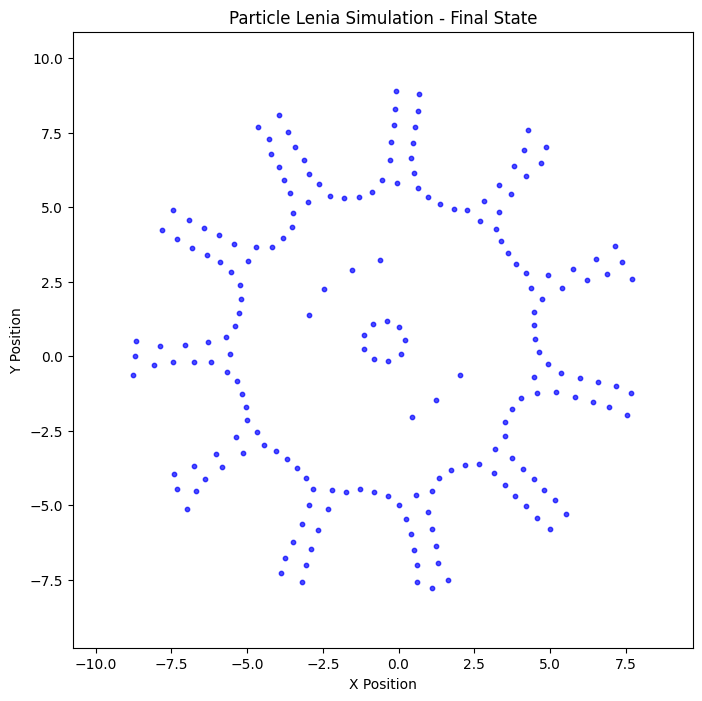

In [6]:
# Plot the last frame of the simulation

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Get the last frame (final positions of all particles)
final_positions = states[-1]  # Shape: (200, 2)

# Create scatter plot of the final positions
ax.scatter(final_positions[:, 0], final_positions[:, 1], s=10, c="blue", alpha=0.7)

# Set axis limits based on the data range with some margin
x_min, x_max = final_positions[:, 0].min(), final_positions[:, 0].max()
y_min, y_max = final_positions[:, 1].min(), final_positions[:, 1].max()
margin = 2  # Add some margin
ax.set_xlim(x_min - margin, x_max + margin)
ax.set_ylim(y_min - margin, y_max + margin)

# Add labels and title
ax.set_title("Particle Lenia Simulation - Final State")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")

# Display the plot
plt.show()

In [ ]:
# Create an animation showing the 256 generations of the 200 particles positions
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML

# Increase the animation embed limit to 30MB (default is 20MB)
mpl.rcParams["animation.embed_limit"] = 1000  # in MB

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize scatter plot
scatter = ax.scatter([], [], s=10, c="blue", alpha=0.7)

# Set axis limits based on the data range
x_min, x_max = states[:, :, 0].min(), states[:, :, 0].max()
y_min, y_max = states[:, :, 1].min(), states[:, :, 1].max()
margin = 2  # Add some margin
ax.set_xlim(x_min - margin, x_max + margin)
ax.set_ylim(y_min - margin, y_max + margin)
ax.set_title("Particle Lenia Simulation")
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")


# Animation update function
def update(frame):
	# Update the scatter plot with new positions
	scatter.set_offsets(states[frame])
	ax.set_title(f"Particle Lenia Simulation - Generation {frame}")
	return (scatter,)


# Create the animation with fewer frames
ani = animation.FuncAnimation(fig, update, frames=len(states), interval=10, blit=True)

# Display the animation
HTML(ani.to_jshtml())